# Naive Bayes for classification


Spring 2021 - Instructors: Roger Stein and Ben Wolfson

Teaching Assistant: Ben Wolfson
***

To open notebook in Colab please click below:

<a href="https://colab.research.google.com/github/bwolfson2/data_biz_2021/blob/main/Module_6_NaiveBayes/NaiveBayes.ipynb" target="_parent"> <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" /> </a>'

In [5]:
#If opening in colab run this cell
!git clone https://github.com/bwolfson2/foster_2021
%cd foster_2021/Module2_Supervised/

Cloning into 'foster_2021'...
remote: Enumerating objects: 656, done.
remote: Counting objects: 100% (547/547), done.
remote: Compressing objects: 100% (406/406), done.
remote: Total 656 (delta 278), reused 383 (delta 130), pack-reused 109
Receiving objects: 100% (656/656), 68.68 MiB | 20.31 MiB/s, done.
Resolving deltas: 100% (317/317), done.
Checking out files: 100% (131/131), done.
/content/foster_2021/Module2_Supervised


In this short notebook, we will explore how Naive Bayes (NB) classifier works.  It will also give us a chance to review some of the other tools and techniques we have been studying.

We begin, as ususal with housekeeping and `import`ing the libraries we will be using.

In [6]:
# Import the libraries we will be using
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from sklearn import preprocessing
from sklearn import metrics

from sklearn.naive_bayes import CategoricalNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split

import statsmodels.formula.api as smf

For this excercise, we will return to the Titanic data set so we can compare the NB results with those we got before using CART and logistic regression.

In [7]:
# Load data
# path = "./data/titanic.csv"
path="./data/"
fn = "titanic.csv"
full_path= path+fn
df = pd.read_csv(full_path)[["survived", "pclass", "sex", "age", "fare"]].dropna()

# Data preparation and preprocessing

As we did the last time we looked at the Titanic data, we will start by recoding some columns and cleaning up any erant records.

In [8]:
# Transform sex column to a numeric variable
df["female"] = (df.sex == "female").astype(int)
df = df.drop("sex", axis="columns")

# Drop 'outliers'. This is to help the visualization in the next examples.
# --> In general, identifying and determining whether / how to deal with outliers is non-trival
df = df[df.fare < 400]

# Take a look at the data
df.head()

,survived,pclass,age,fare,female
0,1.0,1.0,29.0000,211.3375,1
1,1.0,1.0,0.9167,151.5500,0
2,0.0,1.0,2.0000,151.5500,1
3,0.0,1.0,30.0000,151.5500,0
4,0.0,1.0,25.0000,151.5500,1


(Always, always, always, take a look at your data!)

We will set up an *insample* training set and an *out-of-sample* test set.  To keep things simple, we will simply use random sampling.  (Is this the right thing to do?  Why or why not?)  We will sample records by randomly selecting them with a fixed probability.  One easy way to do this is to just create an index of `1`s and `0`s indicating the records we wish to include in the training set and test set, respectively.

In [16]:
np.random.seed(seed=124)                        # Legacy function.  Not best practice.  
                                                # See documentation for: numpy.random.seed
nrow           = df.shape[0] 
runif          = np.random.uniform(size=nrow)
insample_pct   = 0.6666
insample_flag  = [x <  insample_pct for x in runif]
outsample_flag = [x >= insample_pct for x in runif]

train_df  = df.iloc[insample_flag,:]
test_df   = df.iloc[outsample_flag,:]

train_df.describe()
test_df.head()
train_df.shape

(702, 5)

In [ ]:
# We could also have used the column definitions we create later on, and then done: 
#
#     X = df[predictor_cols]
#     y = df[target_cols]
#     X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1-insample_pct, random_state=42)
#
#  and then 
#
#     train_df= X_train.append(y_train)
#     test_df = X_test.append(y_test)
#
#  but in this case, it is less convenient.

The version of Naive Bayes we are using here  works best with categorical data, so I will need to create some buckets for the continuous variables in the data set. I can use the `pandas.cut` function to do this. I have decided to use the quantiles of the distribution as my bucket boundaries.  I will use the quantiles from the training data to bucket both the training and test sets.  (Why?) 

In [17]:
quantile_cuts_a = [0, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 1]

age_quantiles   = np.quantile(train_df.age,quantile_cuts_a)

age_bin         = pd.cut(train_df["age"], bins=age_quantiles, include_lowest=True, labels=['0-5th','05-10th','10-25th','25-50th','50-75th','75-90th','90-95th','95-100th'])
age_bin_num     = pd.cut(train_df["age"], bins=age_quantiles, include_lowest = True, labels=False)
train_df        = train_df.assign(age_bin=age_bin)
train_df        = train_df.assign(age_bin_num=age_bin_num)

age_bin         = pd.cut(test_df["age"], bins=age_quantiles, labels=['0-5th','05-10th','10-25th','25-50th','50-75th','75-90th','90-95th','95-100th'])
age_bin_num     = pd.cut(test_df["age"], bins=age_quantiles, labels=False)
test_df         = test_df.assign(age_bin=age_bin)
test_df         = test_df.assign(age_bin_num=age_bin_num)


quantile_cuts_f = [0, 0.25, 0.75, 1]

fare_quantiles  = np.quantile(train_df.fare,quantile_cuts_f)

fare_bin        = pd.cut(train_df["fare"], bins=fare_quantiles, include_lowest=True, labels=['low','med','high'])
fare_bin_num    = pd.cut(train_df["fare"], bins=fare_quantiles, include_lowest=True, labels = False)
train_df        = train_df.assign(fare_bin=fare_bin)
train_df        = train_df.assign(fare_bin_num=fare_bin_num)

fare_bin        = pd.cut(test_df["fare"],  bins=fare_quantiles, include_lowest=True, labels=['low','med','high'])
fare_bin_num    = pd.cut(test_df["fare"],  bins=fare_quantiles, include_lowest=True, labels = False)
test_df         = test_df.assign(fare_bin=fare_bin)
test_df         = test_df.assign(fare_bin_num=fare_bin_num)


In [18]:
# Names of different columns
target_col          = "survived"
categorical_cols    = ['age_bin','fare_bin']
predictor_cols      = ["pclass", "female",'age_bin','fare_bin']
predictor_cols_num  = ["pclass", "female",'age_bin_num','fare_bin_num']

We can now take a look at our binning and see how the data is distributed across buckets.

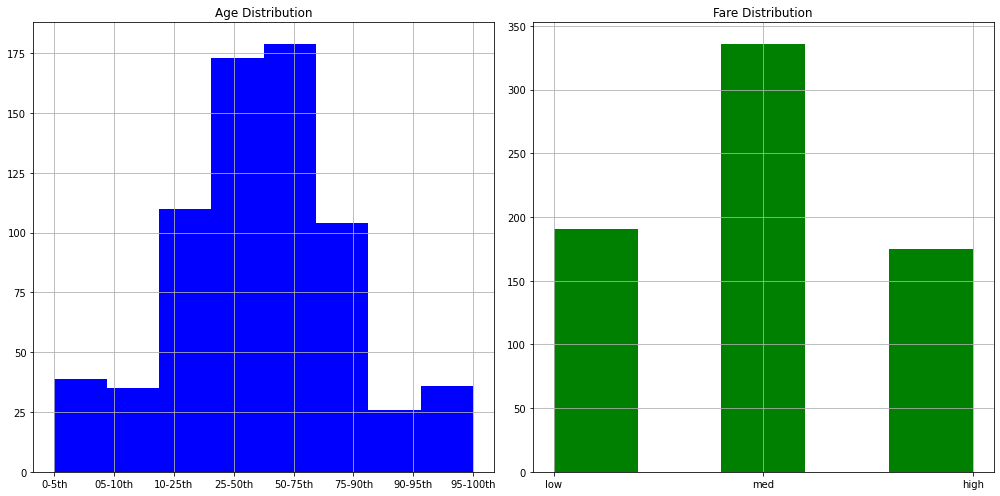

In [19]:
fig, axs  = plt.subplots(ncols=2, nrows=1, figsize=(14, 7))
axs = axs.flatten()
train_df.sort_values(by='age_bin').age_bin.hist(ax=axs[0], bins=8,color='blue')
axs[0].set_title("Age Distribution")
plt.tight_layout()
train_df.sort_values(by='fare_bin').fare_bin.hist( ax=axs[1],bins = 5, color='green')
axs[1].set_title("Fare Distribution")
plt.tight_layout()


In [ ]:
train_df.head()

,survived,pclass,age,fare,female,age_bin,age_bin_num,fare_bin,fare_bin_num
0,1.0,1.0,29.0,211.3375,1,50-75th,4,high,2
2,0.0,1.0,2.0,151.5500,1,0-5th,0,high,2
3,0.0,1.0,30.0,151.5500,0,50-75th,4,high,2
4,0.0,1.0,25.0,151.5500,1,25-50th,3,high,2
5,1.0,1.0,48.0,26.5500,0,75-90th,5,med,1


In [ ]:
test_df.head()

,survived,pclass,age,fare,female,age_bin,age_bin_num,fare_bin,fare_bin_num
1,1.0,1.0,0.9167,151.5500,0,0-5th,0,high,2
6,1.0,1.0,63.0000,77.9583,1,95-100th,7,high,2
9,0.0,1.0,71.0000,49.5042,0,95-100th,7,high,2
13,1.0,1.0,26.0000,78.8500,1,25-50th,3,high,2
18,1.0,1.0,32.0000,76.2917,1,50-75th,4,high,2


# Logit model:
As always, I will start with a logit model, to get a feel for the data and to use as a benchmark.

Since I will be using `statsmodels.api`, I can use formulas rather than restructuring my data each time I want to change the variables included in my model.

In [ ]:
# We could use this:
#
#   df = sm.add_constant(df, prepend=False)
#   predictor_cols = 'const' + predictor_cols
#   model = sm.Logit(df[target_col], df[predictor_cols])
#   logit_model_sm = model.fit()
#
# But using formulas is easier...

In [20]:
# set up the formula for logit  
#   This is a general code snippet that will always work, even if we don't know the formula
#   In this case, of course, I do know the formua and could just write: survived ~ pclass + female + age_bin + fare_bin
#

my_formula=target_col + ' ~ '
for i in range(len(predictor_cols)):
    if i > 0:
        my_formula = my_formula + " + "       
    my_formula = my_formula + predictor_cols[i]
print("Formula: ", my_formula)

Formula:  survived ~ pclass + female + age_bin + fare_bin


In [21]:
model = smf.logit(my_formula, data = train_df)  # Calling the Class (statsmodels is a little different than sklearn)
logit_model_sm = model.fit()                    # Fitting the data to the classifier

Optimization terminated successfully.
         Current function value: 0.468573
         Iterations 6


In [22]:
# we could also have used sklearn:
#
#   logit_model = linear_model.LogisticRegression()
#   logit_model.fit(X=df[predictor_cols], y=df[target_col])
#
# but then we would not be able to do the following analysis:

In [23]:
print(logit_model_sm.summary())

                           Logit Regression Results                           
Dep. Variable:               survived   No. Observations:                  702
Model:                          Logit   Df Residuals:                      690
Method:                           MLE   Df Model:                           11
Date:                Tue, 27 Jul 2021   Pseudo R-squ.:                  0.3062
Time:                        07:05:16   Log-Likelihood:                -328.94
converged:                       True   LL-Null:                       -474.10
Covariance Type:            nonrobust   LLR p-value:                 9.506e-56
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               3.7294      0.820      4.549      0.000       2.122       5.336
age_bin[T.05-10th]     -1.3806      0.594     -2.324      0.020      -2.545      -0.216
age_bin[T.10-25t

Wow!  Every one of the buckets appears to be significant in the regression.  Which ones affect the probabilty of survival the most?

I can examine the marginal effects to get a sense of this for the typical case.  (Why is this the typical case?  Would it be different for a specific record?  Why or why not?)

In [24]:
mfx = logit_model_sm.get_margeff()
print(mfx.summary())

        Logit Marginal Effects       
Dep. Variable:               survived
Method:                          dydx
At:                           overall
                         dy/dx    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
age_bin[T.05-10th]     -0.2083      0.089     -2.351      0.019      -0.382      -0.035
age_bin[T.10-25th]     -0.3371      0.074     -4.568      0.000      -0.482      -0.192
age_bin[T.25-50th]     -0.2922      0.069     -4.208      0.000      -0.428      -0.156
age_bin[T.50-75th]     -0.3192      0.069     -4.645      0.000      -0.454      -0.184
age_bin[T.75-90th]     -0.3975      0.074     -5.378      0.000      -0.542      -0.253
age_bin[T.90-95th]     -0.3285      0.099     -3.304      0.001      -0.523      -0.134
age_bin[T.95-100th]    -0.4533      0.094     -4.845      0.000      -0.637      -0.270
fare_bin[T.med]        -0.1125      0.044     -2.569    

If I graph the marginal effects, I can get a much better sense of which variables move the proability of survival up or down the most.  (The code for coloring the bars and adding notations on the x-axis is a little hackey...)

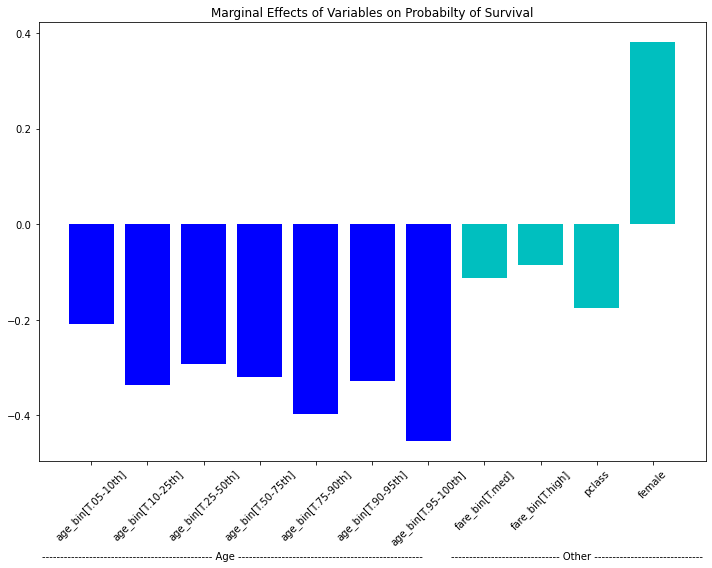

In [ ]:
mfx_names = logit_model_sm.params.index[1:]
plt.figure(figsize = (10,8))
plt.bar(mfx_names,mfx.margeff,color=["b","b","b",'b',"b","b","b","c","c","c","c"])
plt.xticks(rotation=45)
plt.title("Marginal Effects of Variables on Probabilty of Survival")
# total hack for extra notation on x axis !!
plt.xlabel("----------------------------------------------- Age ---------------------------------------------------         ------------------------------ Other ------------------------------")
plt.tight_layout()


Let's see ho w we do out of sample...

In [25]:
pred_glm     = logit_model_sm.predict(test_df)
pred_bin_glm = np.where(pred_glm > 0.5, True, False)  # sk.metrics needs discrete valued data

sm_logit_skm_accuracy = metrics.accuracy_score(pred_bin_glm, test_df.survived)
print ("Accuracy (sm logit) fr SKM = %.2f" % sm_logit_skm_accuracy)

Accuracy (sm logit) fr SKM = 0.80


# Naive Bayes

There are several NB claissifers available in `sklearn`, so to fit a Naive Bayes classifier, we will follow the same template as we have for other `sklearn` algorithms.  However, the Naive Bayes claissifier can't use formuae and expects numerical categories, so we need to use the numerically coded categories, rather than the text labeled categories. 

In [26]:
X_train = train_df[predictor_cols_num]
y_train = train_df[target_col]
X_test  = test_df[predictor_cols_num]
y_test  = test_df[target_col]

As usual, we only need two lines of code to fit a model in `sklearn`, once we have gotten our data set up.

In [27]:
naive_bayes = CategoricalNB()          # Calling the Class
naive_bayes.fit(X_train, y_train)      # Fitting the data to the classifier

CategoricalNB(alpha=1.0, class_prior=None, fit_prior=True)

We check our results...

In [28]:
pred_nb      = naive_bayes.predict_proba(X_test)[:,1]  # Predict on test data
pred_bin_nb  = np.where(pred_nb > 0.5, True, False)    # sk.metrics needs discrete valued data

skl_nb_skm_accuracy = metrics.accuracy_score(pred_bin_nb, test_df.survived)
print ("Accuracy (naive bayes) fr SKM = %.2f" % skl_nb_skm_accuracy)

Accuracy (naive bayes) fr SKM = 0.72


# Decison Tree

Finally, we see how a recursive partitioning algorithm will build a tree from the same data.

In [30]:
decision_tree = DecisionTreeClassifier(max_depth=3, criterion="entropy")       # Calling the Class
decision_tree.fit(train_df[predictor_cols_num], train_df[target_col])          # Fitting the data to the classifier

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [31]:
pred_CART = decision_tree.predict_proba(X_test)[:,1]                           # Predict on test data
pred_bin_CART  = np.where(pred_CART > 0.5, True, False)                        # sk.metrics needs discrete valued data

skl_CART_skm_accuracy = metrics.accuracy_score(pred_bin_CART, test_df.survived)
print ("Accuracy (decision tree) fr SKM = %.2f" % skl_CART_skm_accuracy)

Accuracy (decision tree) fr SKM = 0.81


# Evaluating the models's power

I will write a short little bit of code to make plotting ROC curves for multiple models easier.  Since I will also want to be able to simply look at the AUCs without plotting sometimes, I built that funcitionality as well. 

In [32]:
def get_model_roc_1(preds, Xs_test, names, Y_test, show_plot=True):  #this lets us run through multiple models
    if show_plot:
        plt.rcParams['figure.dpi'] = 70
        plt.figure(figsize = (5,5))
        for i in range(len(preds)):  # here, each i is one of the models
            scores = preds[i]
            X_test = Xs_test[i]
            name = names[i]
            fpr, tpr, thresholds = metrics.roc_curve(Y_test, scores)
            plt.plot(fpr, tpr, label=name)
            plt.plot([0, 1], [0, 1], linestyle='dashed', color='black')
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("ROC Curve")
        plt.legend()
        plt.tight_layout()
    else:
         for i in range(len(preds)):  # here, each i is one of the models
            scores = preds[i]
            X_test = Xs_test[i]
            name = names[i]
            fpr, tpr, thresholds = metrics.roc_curve(Y_test, scores)
            print ("AUC for {0} = {1:.3f}".format(name, metrics.roc_auc_score(Y_test, scores)))

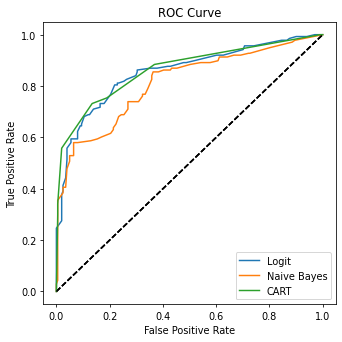

In [33]:
get_model_roc_1([pred_glm, pred_nb, pred_CART], [X_test, X_test, X_test], ["Logit", 'Naive Bayes', 'CART'], y_test)

In [ ]:
get_model_roc_1([pred_glm, pred_nb, pred_CART], [X_test, X_test, X_test], ["Logit", 'Naive Bayes', 'CART'], y_test, False)

AUC for Logit = 0.855
AUC for Naive Bayes = 0.812
AUC for CART = 0.864


It looks like the more sophisticated models did a better job than Naive Bayes in this case, which is not really suprising.  While NB is easy and flexible, it makes very strong assumptions about the data, which can limit its accuracy.